In [1]:
import scanpy as sc
import squidpy as sq
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import Counter
from matplotlib_scalebar.scalebar import ScaleBar
import os
import cell2location
from scipy.stats import chi2_contingency
import statsmodels.stats.multitest as sm

DPI = 300
FONTSIZE = 20  # 42
sc.settings.set_figure_params(
    scanpy=True, dpi=60, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

import seaborn as sns
from pathlib import Path

custom_params = {"font.size": FONTSIZE, "figure.dpi": 100, "savefig.dpi": DPI}
sns.set_theme(style="ticks", rc=custom_params)

# QC utils functions - a package
from vistools import utils
from vistools import spatial_plots

Global seed set to 0


In [2]:
SAMPLE_NAME = "CRC11_LM_VISIUM" #"CRC11_LM_VISIUM" # "Wu2022_ST_LM4"

if "Wu" in SAMPLE_NAME:
    # load cell2location results
    DIR2LOAD = Path(
        f"/data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Wu_2022/cell2location/{SAMPLE_NAME}"
    )
    DIR2LOAD.mkdir(parents=True, exist_ok=True)

    run_name = DIR2LOAD.joinpath(f"cell2location_map-no_cycling_TME/")
    run_name.mkdir(parents=True, exist_ok=True)

    # load gene expression
    DIR2GENEXP = Path(f"/data/BCI-CRC/nasrine/data/CRC/spatial/public/Visium_Wu_2022/qc/{SAMPLE_NAME}/{SAMPLE_NAME}_raw.h5ad")
    adata_genexp = sc.read_h5ad(DIR2GENEXP)
    
if "CRC" in SAMPLE_NAME:
    # load cell2location results
    DIR2LOAD = Path(
        f"/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/cell2location/{SAMPLE_NAME}"
    )
    DIR2LOAD.mkdir(parents=True, exist_ok=True)

    run_name = DIR2LOAD.joinpath(f"cell2location_map-no_cycling_TME/")
    run_name.mkdir(parents=True, exist_ok=True)

    # load gene expression
    DIR2GENEXP = Path(f"/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/qc/{SAMPLE_NAME}/{SAMPLE_NAME}_raw.h5ad")
    adata_genexp = sc.read_h5ad(DIR2GENEXP)    

# load joint analysis of microenvrionmentts
MICROENV_DIR = Path("/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/cell2loc_spatialde2/concat_withWu2022/sp_segmentation_smoothness1.2.h5ad")
adata_microenv = sc.read_h5ad(MICROENV_DIR)

# only select spots that are in adata_genexp
adata_microenv = adata_microenv[adata_microenv.obs.index.isin(adata_genexp.obs.index)].copy()

In [3]:
### load LR interactions:
gene_sign = "AP1_regulon_updated" # "AP1_regulon"
receiver = "ipEMT"

LR_DIR = Path("/data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/nichenet/concat_withWu2022/nichenet_microenvall_celltypes/intersect_cellphonedb/")

lr_df = pd.read_csv(LR_DIR.joinpath(f"{gene_sign}{receiver}_final_LR_1Ligand_2_1Receptor.csv"),
                    sep=",",
                    header=0
                   )
lr_df.shape

### save plots in same folder
FIG2SAVE = LR_DIR.joinpath(f"figures/final/{gene_sign}_{receiver}/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)

In [4]:
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)
mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns["mod"]["factor_names"]] = adata_vis.obsm[
    "q05_cell_abundance_w_sf"
]
adata_vis.uns["mod"]["factor_names"]

INFO     File /data/BCI-CRC/nasrine/data/CRC/spatial/CRC_LM_VISIUM/CRC_LM_VISIUM_04_08_09_11/
         cell2location/CRC11_LM_VISIUM/cell2location_map-no_cycling_TME/model.pt already     
         downloaded                                                                          
INFO     Preparing underlying module for load                                                


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
/data/BCI-CRC/nasrine/anaconda/envs/cell2loc19/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/30000:   0%|          | 1/30000 [00:01<10:57:19,  1.31s/it, v_num=1, elbo_train=3.26e+7]


array(['B', 'C1QC Mac', 'C3 iCAF', 'CD4 Tfh', 'CD4 Th', 'CD4 Th HSP',
       'CD4 Th17', 'CD4 Tn', 'CD8 Tem', 'CD8 Tem GZMB', 'CD8 Tem HSP',
       'CD8 Tex', 'Cholangiocyte', 'Colonocyte', 'ECM CAF',
       'Enteroendocrine', 'FCN1 Mono', 'Goblet', 'HSP Mono', 'Hepatocyte',
       'Hypoxia', 'IL1B Mac', 'Intermediate', 'Kupffer', 'Lymphatic endo',
       'MAIT', 'Mast', 'Myofibroblast', 'NK1', 'NK2', 'NKT', 'NLRP3 Mac',
       'Neutrophil', 'PLTP LYVE1 Mac', 'Pericyte', 'Plasma', 'SEC', 'SMC',
       'SPP1 Mac', 'Stalk-like endo', 'Stem', 'Stem (NOTUM high)', 'TA1',
       'TA2', 'Tip-like endo', 'Treg', 'Tuft', 'UPR', 'cDC1', 'cDC2',
       'gdT', 'ipEMT', 'migDC', 'pDC', 'pEMT'], dtype=object)

### Idea:
Compute enrichment of ligand / or receptor in spots belonging to microenvironment vs not beloonging t omicroenvironmentt
create contigency table of proportions and compute odds ratio

In [5]:
# create adata gene exp with microenv assignment
adata_genexp.obs = adata_genexp.obs.merge(adata_microenv.obs[["segmentation_labels"]],
                       how="left",
                       left_index=True,
                       right_index=True
                      )

In [6]:
adata_genexp.obs.segmentation_labels.cat.categories

Int64Index([0, 2, 3, 4, 5, 6, 7, 8], dtype='int64')

In [7]:
### log normalise 
# keep raw
adata_genexp.layers["raw"] = adata_genexp.X.copy()  # preserve counts

# normalize + log1p
sc.pp.normalize_total(adata_genexp, target_sum=1e4, inplace=True)
adata_genexp.layers["normalised"] = adata_genexp.X.copy()
sc.pp.log1p(adata_genexp)

adata_genexp.layers["log1p"] = adata_genexp.X.copy()

adata_genexp.raw = adata_genexp  # keep normalised log1p

### calculate total proportion value per condition

In [8]:
def gene_enrichment_env(adata, goi, label_key, nhood_key):
    """
    Computes odds ratio using 2 x 2 contingency table (microenv, non_microenv) x (gene of interest, other genes)
    Computes the chi-square statistic and p-value with `scipy.stats.chi2_contingency` to assess statistical
    significance.
    stats.contingency.odds_ratio to conclude ligand is enriched in spatial neighbourhood
    
    @param adata: adata containing gene expression (log normalised)
    @param goi: gene of interest (ligand or receptor to see if enriched in label_key)
    @param label_key: microenvironment of interest present in nhood_key
    @param nhood_key: Key in :attr:`anndata.AnnData.obs` that contains annotations for cellular neighbourhoods
    """
    
    # define genes that are not the gene of interest (goi gene)
    other_genes = list(set(adata.var_names)-set(goi))
    
    # separate adata into env and non-env spots
    adata_env = adata[adata.obs[nhood_key].isin(label_key),:].copy()
    adata_nonenv = adata[~adata.obs[nhood_key].isin(label_key),:].copy()
    
    # sum all spots expressing goi gene to get nb of spots expressing goi gene
    #                gene_of_interest | other genes
    #            ......................................
    # microenv     :      env_goi     | env_other_genes
    # non_microenv :     nonenv_goi   | nonenv_other_genes
    # odds ligand expressed in neighbourhod env
    env_goi = np.sum(adata_env[:, goi].X.todense()>0, axis=0)[0,0] 
    nonenv_goi = np.sum(adata_nonenv[:, goi].X.todense()>0, axis=0)[0,0] 
    # odds other genes expressed in neighbourhod env
    env_other_genes = np.sum(np.sum(adata_env[:, other_genes].X.todense()>0, axis=1))
    nonenv_other_genes = np.sum(np.sum(adata_nonenv[:, other_genes].X.todense()>0, axis=1))
    
    # contingency table: 2 categories (microenv, non-microenv) x 2 categories (goi:gene of interest, other genes)
    cont_table = np.array([[env_goi,nonenv_goi],
                           [env_other_genes,nonenv_other_genes]])
    
    # calculate logOR : odds ligand expressed in neighbourhood vs odds other genes expressed in neighbourhood
    logOR = np.log((env_goi/nonenv_goi)/(env_other_genes/nonenv_other_genes))
    # calculate SE: standard error for the log odds ratio is approximately SE = sqrt(1/a + 1/b + 1/c + 1/d))
    SE = np.sqrt((1/env_goi)+(1/nonenv_goi)+(1/env_other_genes)+(1/nonenv_other_genes))
    
    # confidence interval: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1255808/ 
    # If we want to indicate the uncertainty around the estimate of the mean measurement, 
    # we quote the standard error of the mean. The standard error is most useful as a means of 
    # calculating a confidence interval. 
    conf_int = 1.96*SE 
    
    # calculate chi-squared value and p-value
    x2, pval, _, _ = chi2_contingency(observed=cont_table, correction=True)
    
    return dict({'logOR':logOR, 'conf_int':conf_int, 'x2':x2, 'pval':pval})

def gene_enrichment_env_multiple_comparisons(adata, gois, label_key, nhood_key, corr_method='fdr_bh'):
    """
    Computes odds ratio and chi-square statistic and associated p-value 
    Corrects for multiple testing by adjusting p-value using Benjamini/Hochberg correction
    using `statsmodels.stats.multitest.multipletests`
    
    @param adata: adata containing gene expression (log normalised)
    @param gois: genes of interest (ligands or receptors to see if enriched in label_key)
    @param label_key: microenvironment of interest present in nhood_key
    @param nhood_key: Key in :attr:`anndata.AnnData.obs` that contains annotations for cellular neighbourhoods
    @param corr_method: method to use for multiple hypothesis testing
    """
    multi_enr = list()
    # compute contigency table and chi-square for each gene of interest
    for g in gois:
        multi_enr.append(gene_enrichment_env(adata=adata, 
                                             goi=g, 
                                             label_key=label_key, 
                                             nhood_key=nhood_key))
    multi_enr_df = pd.DataFrame(multi_enr)
    multi_enr_df['gene_of_interest'] = gois
    
    # adjust p-value for multiple testing 
    multi_enr_df['pval_adj'] = sm.multipletests(multi_enr_df['pval'], alpha=0.05,
                                                method=corr_method,
                                                is_sorted=False, returnsorted=False)[1]
    
    return multi_enr_df
    

In [9]:
# select ligands to test (only if present in visium data)
ligands2test = [ele for ele in lr_df['from'].unique() if ele in adata_genexp.var_names]
niches = [0, 5] # to define
cluster_key = 'segmentation_labels'

result_df = gene_enrichment_env_multiple_comparisons(adata=adata_genexp, 
                                                     gois=ligands2test,
                                                     label_key=niches,
                                                     nhood_key=cluster_key,
                                                     corr_method='fdr_bh'
                                                    )
result_df.sort_values('logOR', ascending=False, inplace=True)
result_df.head(5)

,logOR,conf_int,x2,pval,gene_of_interest,pval_adj
20,1.654195,0.900560,13.862664,1.966670e-04,FGF1,3.662074e-04
37,1.475504,0.283839,121.954355,2.362103e-28,OSM,4.251786e-27
5,1.273423,0.406008,41.426603,1.223806e-10,CDH2,3.146929e-10
6,1.236963,0.185210,192.635429,8.454620e-44,COL15A1,4.565495e-42
53,1.230381,0.643989,14.228456,1.619037e-04,WNT5A,3.122428e-04


In [10]:
result_df.to_csv(LR_DIR.joinpath(f"{gene_sign}{receiver}_{SAMPLE_NAME}_enrichment_ligands.csv"), 
                 header=True, index=False
               )

### plotting

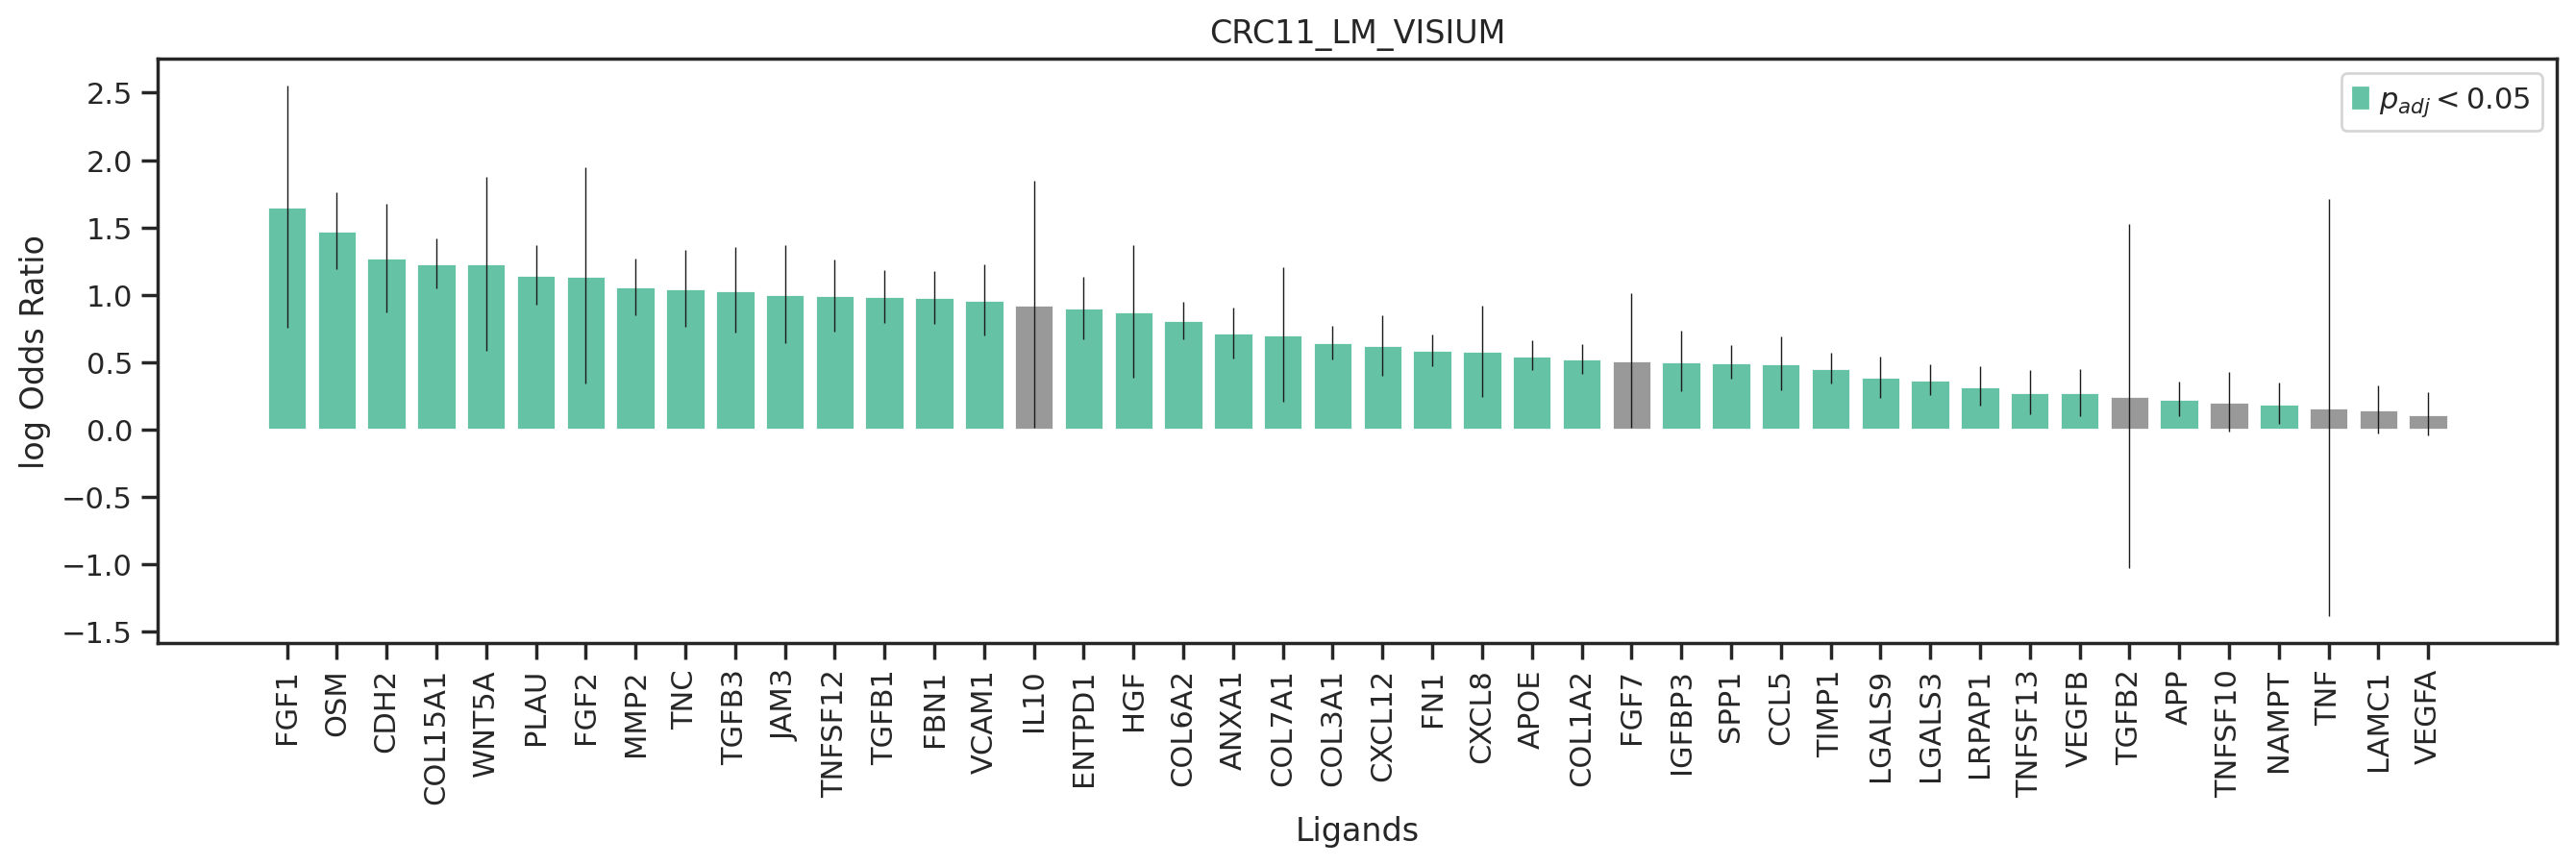

In [11]:
pval_adj_thresh = 0.05
subset = "enriched" #"enriched" #"all"
col_sign = '#66c2a5'
col_nonsign = '#999999'


# only select those that are enriched in the microenv
if subset=="enriched":
    result_df2plot = result_df[result_df['logOR']>0]
if subset=="all":
    result_df2plot = result_df

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
# set color based on adjusted p-value
color=[col_sign if p<pval_adj_thresh else col_nonsign for p in result_df2plot['pval_adj']]
ax.bar(x=result_df2plot['gene_of_interest'], 
       height=result_df2plot['logOR'], 
       color=color, 
       yerr=result_df2plot['conf_int'],
       error_kw={'elinewidth':0.5})
ax.set_ylabel("log Odds Ratio")
ax.set_xlabel("Ligands")
ax.set_title(f"{adata_genexp.obs.Sample.unique()[0]}")
ax.tick_params(axis='x', labelrotation = 90)
ax.legend(handles=[plt.Rectangle((0,0),1,1, color=col_sign)],labels=['$p_{adj} < $'+str(pval_adj_thresh)])
plt.savefig(FIG2SAVE.joinpath(
    f'{gene_sign}_{receiver}_{SAMPLE_NAME}_enrichment_ligands_microenvs{"_".join(str(ele) for ele in niches)}_{subset}.pdf'), 
            dpi=DPI,
            format="pdf", bbox_inches="tight",)

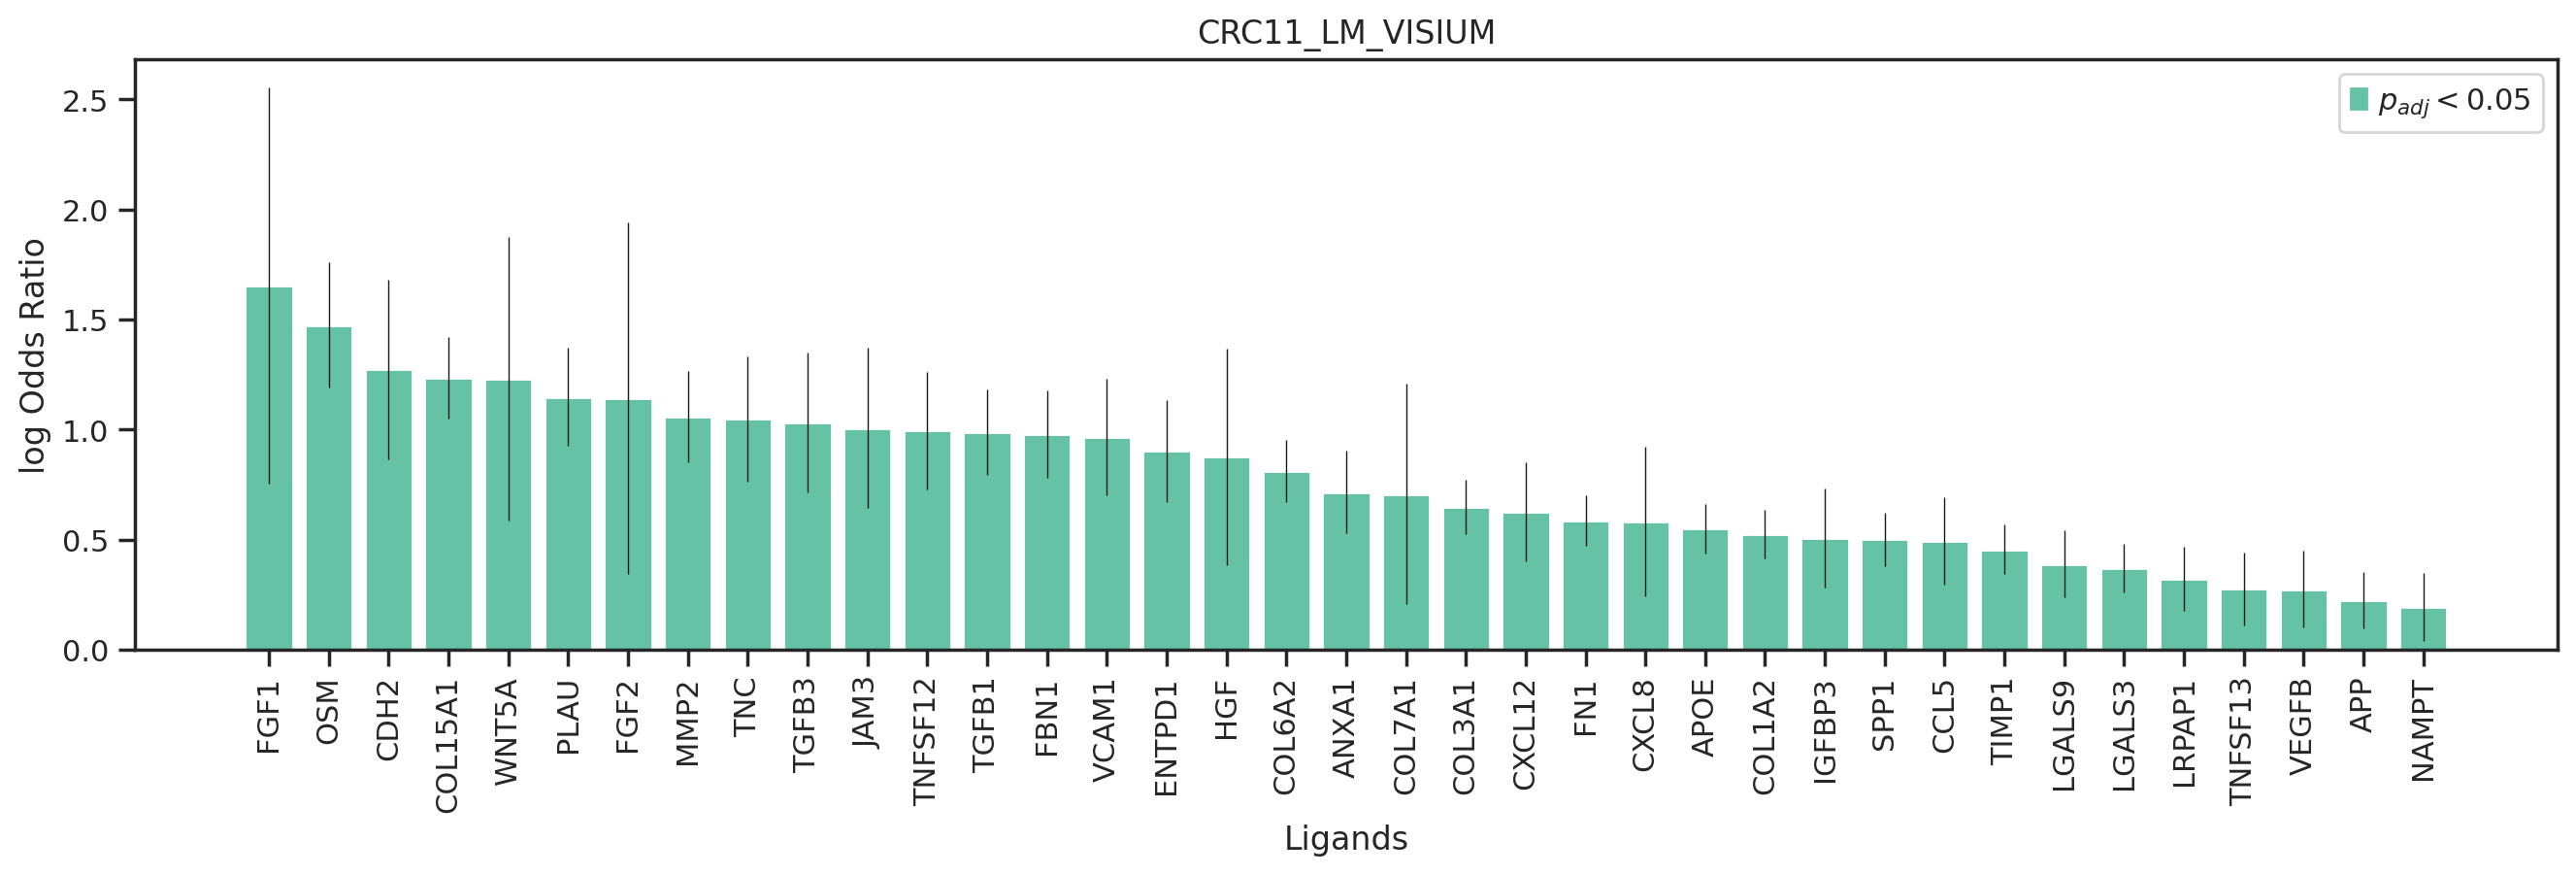

In [12]:
# only plot the significant ones 
result_df2plot = result_df2plot[result_df2plot['pval_adj']<pval_adj_thresh].copy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,4))
# set color based on adjusted p-value
color=[col_sign if p<pval_adj_thresh else col_nonsign for p in result_df2plot['pval_adj']]
ax.bar(x=result_df2plot['gene_of_interest'], 
       height=result_df2plot['logOR'], 
       color=color, 
       yerr=result_df2plot['conf_int'],
       error_kw={'elinewidth':0.5})
ax.set_ylabel("log Odds Ratio")
ax.set_xlabel("Ligands")
ax.set_title(f"{adata_genexp.obs.Sample.unique()[0]}")
ax.tick_params(axis='x', labelrotation = 90)
ax.legend(handles=[plt.Rectangle((0,0),1,1, color=col_sign)],labels=['$p_{adj} < $'+str(pval_adj_thresh)])
plt.savefig(FIG2SAVE.joinpath(
    f'{gene_sign}_{receiver}_{SAMPLE_NAME}_enrichment_ligands_microenvs{"_".join(str(ele) for ele in niches)}_{subset}_onlypval.pdf'), 
            dpi=DPI,
            format="pdf", bbox_inches="tight",)